V tem "notebooku" bom poskusil izdelati ti. "Credit default" model, ki bo iz danih podatkov o komitentih (najemnikih posojila) napovedal, ali bo slednji dolg odplačal ali ne. Podatke sem pridobil z naslednje spletne strani: https://www.kaggle.com/wendykan/lending-club-loan-data

In [2]:
library(ggplot2)
library(rvest)
library(gsubfn)
library(readr)
library(dplyr)
library(readxl)

Uvoženi podatki se nahajajo v dveh tabelah. Prva tabela vsebuje spremenljivke in njihove opise (pomene). V drugi (glavni) so zbrani podatki o posameznih najemnikih posojil. Gre za ogromno podatkovno zbirko, saj obsega podatke o kar slabih 900.000 osebah, pri vsaki pa je shranjenih 74 spremenljivk.

Podatki so že v "tidy-data" obliki, niso pa še pripravljeni za nadaljnjo analizo (prevelika količina spremenljivk za učinkovito in pregledno delo). Prva faza bo tako obsegala izbor najpomembnejših spremenljivk (želeno število je okoli 20). Za lažje delo v nadaljevanju bom tudi zmanjšal število komitentov v bazi (sam uvoz celotnih podatkov je namreč trajal cca 5 minut) na približno 80.000, kar predstavlja 10% začetnih podatkov.

In [9]:
info = read_excel("filesCredit/LCDataDictionary.xlsx")

In [13]:
head(info)

LoanStatNew,Description
addr_state,The state provided by the borrower in the loan application
annual_inc,The self-reported annual income provided by the borrower during registration.
annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
collection_recovery_fee,post charge off collection fee
collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections


In [8]:
#datoteka loan.csv se ne nahaja več v tem repozitoriju (prevelika datoteka, da bi jo naložil na github)
loadData = read.csv("loan.csv", header=T)

In [33]:
head(loadData)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1075358,1311748,3000,3000,3000,60 months,12.69,67.79,B,B5,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [18]:
dim(loadData)

[1] 887379     74

Pri izbiri spremenljivk si pomagam s fukncijo str(loadData), ki mi izpiše podrobnejše informacije o posameznih spremenljivkah. Nekaj razlogov za odstranitev posameznih spremenljivk:
- "emp_title", "url", "desc" ... : pri vseh gre za to, da so prevelike oz. preveč specifične za smiselno analizo ("emp_title" tako vsebuje kar slabih 300.000 različnih vnosov).
- "member_id", "revol_bal", "funded_amnt" ... : informacije so zajete že v drugih spremenljivkah, ne doprinesejo bistveno novih informacij k celoti ("funded_amnt" se od "loan_amnt" v povprečju razlikuje za samo 13$).
- "pymnt_plan", "application_type" : binarne spremenljivke. Od tega manj kot 0,5% vnosov pripada enemu razredu, tako da so praktično vse spremenljivke v istem razredu.
- "tot_coll_amt", "tot_cur_bal", "open_acc_6m" ... : večina vnosov je NA.

In [19]:
str(loadData)

'data.frame':	887379 obs. of  74 variables:
 $ id                         : int  1077501 1077430 1077175 1076863 1075358 1075269 1069639 1072053 1071795 1071570 ...
 $ member_id                  : int  1296599 1314167 1313524 1277178 1311748 1311441 1304742 1288686 1306957 1306721 ...
 $ loan_amnt                  : num  5000 2500 2400 10000 3000 ...
 $ funded_amnt                : num  5000 2500 2400 10000 3000 ...
 $ funded_amnt_inv            : num  4975 2500 2400 10000 3000 ...
 $ term                       : Factor w/ 2 levels " 36 months"," 60 months": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate                   : num  10.6 15.3 16 13.5 12.7 ...
 $ installment                : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                      : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ sub_grade                  : Factor w/ 35 levels "A1","A2","A3",..: 7 14 15 11 10 4 15 21 27 10 ...
 $ emp_title                  : Factor w/ 299273 levels "","'Property Manager",..

In [22]:
mean(abs(loadData$loan_amnt - loadData$funded_amnt))
mean(abs(loadData$loan_amnt - loadData$funded_amnt_inv))
mean(loadData$loan_amnt)

[1] 13.38698

[1] 52.80022

[1] 14755.26

In [25]:
sum(loadData$pymnt_plan == 'n')

[1] 887369

In [35]:
mean(abs(loadData$out_prncp - loadData$out_prncp_inv))

[1] 3.41161

In [36]:
sum(loadData$total_rec_late_fee)

[1] 352016

In [38]:
sum(loadData$application_type == 'JOINT')

[1] 511

In [9]:
downsampl <- loadData[sample(nrow(loadData), 80000), ]

In [10]:
downsampl <- downsampl[,c("id", "loan_amnt", "int_rate", "installment", "grade", "sub_grade", "emp_length", "home_ownership", 
                    "annual_inc", "verification_status", "issue_d", "purpose", "addr_state", "dti", "open_acc", 
                    "revol_util", "total_acc", "out_prncp", "total_pymnt", "total_rec_late_fee", "last_pymnt_d", "loan_status")]

Sedaj dobim tabelo dimenzije 80.000 x 21. Podatki so v pravi obliki (za vsakega komitenta je shranjenih najpomembnejših 21 spremenljivk). Na koncu tabelo shranim v "loanDownsample.csv". 

In [28]:
dim(downsampl)

[1] 80000    21

In [26]:
rownames(downsampl) <- downsampl$id
downsampl$id <- NULL
head(downsampl)

,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,addr_state,dti,open_acc,revol_util,total_acc,out_prncp,total_pymnt,total_rec_late_fee,last_pymnt_d,loan_status
66370404,3500,10.64,113.99,B,B4,2 years,RENT,42000,Source Verified,Dec-2015,...,FL,24.43,9,38.6,32,3417.04,111.92,0,Jan-2016,Current
56019943,2575,17.57,92.54,D,D4,10+ years,RENT,36000,Verified,Jul-2015,...,TX,13.67,6,14.5,7,2292.66,457.67,0,Dec-2015,Current
63518390,5275,21.99,201.43,F,F1,10+ years,MORTGAGE,52000,Verified,Oct-2015,...,MO,22.36,8,57.0,9,5063.55,396.42,0,Dec-2015,Current
14600061,15000,19.47,553.42,D,D5,< 1 year,OWN,80000,Verified,Apr-2014,...,VA,28.97,24,68.8,41,0.00,16942.03,0,Dec-2014,Fully Paid
48474794,31000,13.99,721.16,C,C4,10+ years,RENT,86147,Verified,May-2015,...,TX,12.12,7,72.0,14,28001.77,5745.19,0,Jan-2016,Current
40433030,24000,17.14,598.27,D,D4,7 years,MORTGAGE,68000,Source Verified,Feb-2015,...,UT,22.01,9,52.9,22,20980.29,6558.12,0,Jan-2016,Current


In [27]:
write.csv(downsampl, file = "filesCredit/loanDownsample.csv")

Pri preliminarni raziskovalni analizi si bom pomagal s knjižnico "DescTools", ki omogoča enostaven prikaz porazdelitev posameznih spremenljivk.

In [23]:
install.packages('DescTools', dependencies = TRUE, repos = "http://cran.us.r-project.org")
library(DescTools)

Najprej preverim porazdelitev "Loan status". Tu so namreč zbrane informacije o zamudnikih, tj. tistih ki imajo težave pri odplačevanju kredita. Ravno te spremenljivke bom kasneje poskusil napovedati.

Vidim, da gre za primer "unbalanced data". Razredi, ki predstavljajo "težave" (Late, Default, Charged Off), tako skupaj predstavljajo le dobrih 7% celotnih podatkov. 

------------------------------------------------------------------------------ 
Loan status

  length      n    NAs unique levels  dupes
  80'000 80'000      0     10     10      y
         100.0%   0.0%                     

                                                  level    freq   perc  cumfreq  cumperc
1                                               Current  54'128  67.7%   54'128    67.7%
2                                            Fully Paid  18'681  23.4%   72'809    91.0%
3                                           Charged Off   4'215   5.3%   77'024    96.3%
4                                    Late (31-120 days)   1'086   1.4%   78'110    97.6%
5                                                Issued     757   0.9%   78'867    98.6%
6                                       In Grace Period     579   0.7%   79'446    99.3%
7                                     Late (16-30 days)     206   0.3%   79'652    99.6%
8    Does not meet the credit policy. Status:Fully Paid     16

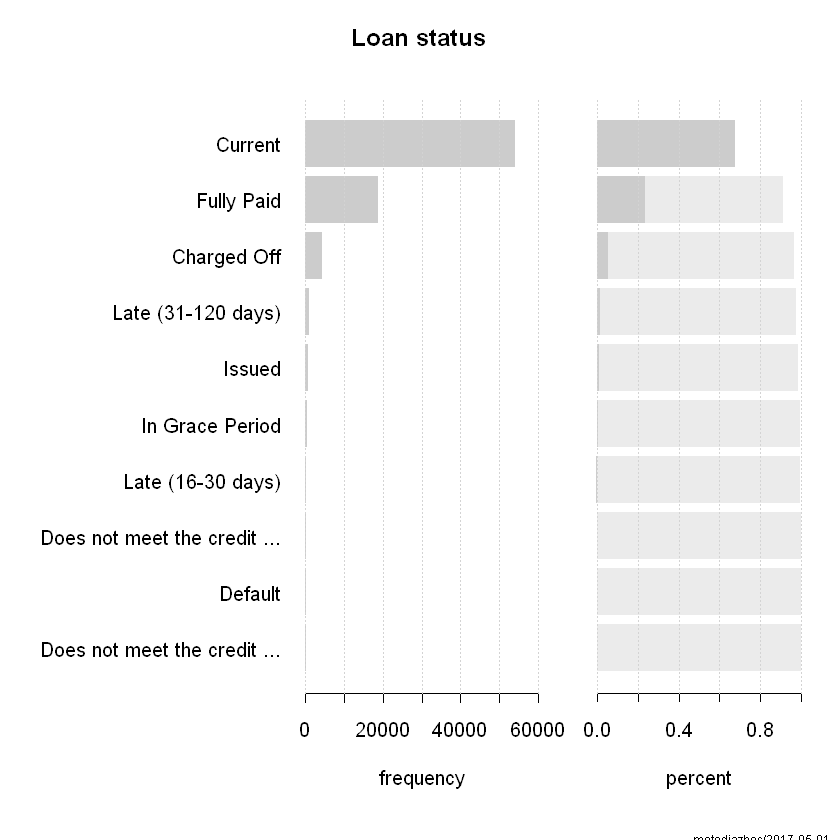

In [31]:
Desc(downsampl$loan_status, main = "Loan status", plotit = T)

Izračunam lahko še povprečni dohodek po kategorijah spremenljivke "loan_status". Vidim, da so rezultati pričakovani. Dolžniki, ki zamujajo ali pri katerih je prišlo do "default-a", imajo v povprečju nižji dohodek. Podobno storim še za obrestno mero in ponovno vidim, da imajo "slabši" najemniki posojila v povprečju višjo obrestno mero (kar je pričakovano, saj banka želi višjo premijo za tveganje).

In [7]:
povprecni_dohodek <- downsampl %>% select(annual_inc, loan_status) %>% 
                        group_by(loan_status) %>% summarise(povpr_dohodek = mean(annual_inc))
povprecni_dohodek <- povprecni_dohodek[with(povprecni_dohodek, order(povpr_dohodek)), ]
#povprecni_dohodek

obrestna <- downsampl %>% select(int_rate, loan_status) %>% 
                        group_by(loan_status) %>% summarise(obr_mera = mean(int_rate))
obrestna <- obrestna[with(obrestna, order(obr_mera)), ]
#obrestna

primer <- merge(povprecni_dohodek, obrestna, by = "loan_status")
primer

loan_status,povpr_dohodek,obr_mera
Charged Off,64714.12,16.11120
Current,76088.21,12.98617
Default,66062.83,16.18345
Does not meet the credit policy. Status:Charged Off,63030.30,14.64195
Does not meet the credit policy. Status:Fully Paid,74186.34,14.03267
Fully Paid,73868.48,13.31570
In Grace Period,72291.44,15.55974
Issued,77725.93,12.55231
Late (16-30 days),72190.86,15.95917
Late (31-120 days),70509.98,15.88438
